<a href="https://colab.research.google.com/github/vamuth/Neural-network-as-an-optimizer-for-point-sets/blob/master/resampling_pointsets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import io_utils
#from loss_fourier import *
#from loss_spherical import *

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import math as m
import os

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

###### helper functions from io_utils

In [ ]:
def read_2Dplane(pointcloud):

    if pointcloud.endswith('.txt'):
        ptc = np.loadtxt(pointcloud)
        temp = np.zeros(ptc.shape[0])
        points3D = np.append(ptc, temp.reshape(-1, 1), axis=1)

    return ptc, points3D

Fourier loss backend functions. This only need to be changed.

In [ ]:
def radialAverage(data):
    resolution = int(data.shape[0])
    xlow = -resolution*0.5
    xhigh = resolution*0.5
    ylow = xlow
    yhigh = xhigh
    u = tf.range(xlow, xhigh, 1.0)
    v = tf.range(ylow, yhigh, 1.0)
    uu, vv = tf.meshgrid(u,v)

    r = tf.sqrt(uu**2 + vv**2)
    rflat = tf.reshape(r, [-1])
    rflat = tf.cast(rflat, tf.int32)

    tbin = tf.math.bincount(rflat, tf.reshape(data, [-1]))
    nr = tf.math.bincount(rflat)
    radialprofile = tf.cast(tbin, tf.float32) / tf.cast(nr, tf.float32)
    return radialprofile[0:int(xhigh)], nr[0:int(xhigh)]

In [ ]:
def computeNoDCExpectedPowerSpectrum(points):

    batchCount = points.shape[0]
    pointCount = points.shape[1]
    dimCount = points.shape[2]
    #print(batchCount, pointCount, points.shape)

    if(dimCount > 4):
        sys.exit("computeNoDCFourierTransform(): only upto 5D is supported!")

    resolution = 64#fourierParams['resolution']
    freqStep = 1 #fourierParams['freqstep']
    #scalingFactor = fourierParams['scaleDC']

    numPoints = float(int(pointCount)) #float(int(points.shape[0])) #tf.convert_to_tensor(X, dtype=tf.float32).get_shape()[0].value
    xlow = -resolution*freqStep*0.5
    xhigh = resolution*freqStep*0.5
    halfres = int(resolution*0.5)
    ylow = xlow
    yhigh = xhigh

    batchGrid = None
    if dimCount == 1:
        u = tf.range(xlow, xhigh, freqStep)
        uu = tf.meshgrid(u)
        grid = tf.to_float(uu)
        batchGrid = tf.tile(tf.expand_dims(grid,0),[batchCount,1,1])
    elif dimCount == 2:
        u = tf.range(xlow, xhigh, freqStep)
        v = tf.range(xlow, xhigh, freqStep)
        uu, vv = tf.meshgrid(u,v)
        grid = tf.cast([uu,vv], dtype= tf.float32)
        batchGrid = tf.tile(tf.expand_dims(grid,0),[batchCount,1,1,1])
    elif dimCount == 3:
        u = tf.range(xlow, xhigh, freqStep)
        v = tf.range(xlow, xhigh, freqStep)
        w = tf.range(xlow, xhigh, freqStep)
        uu, vv, ww = tf.meshgrid(u,v,w)
        grid = tf.to_float([uu,vv,ww])
        batchGrid = tf.tile(tf.expand_dims(grid,0),[batchCount,1,1,1,1])
    elif dimCount == 4:
        u = tf.range(xlow, xhigh, freqStep)
        v = tf.range(xlow, xhigh, freqStep)
        w = tf.range(xlow, xhigh, freqStep)
        p = tf.range(xlow, xhigh, freqStep)
        uu, vv, ww, pp = tf.meshgrid(u,v,w,p)
        grid = tf.to_float([uu,vv,ww,pp])
        batchGrid = tf.tile(tf.expand_dims(grid,0),[batchCount,1,1,1,1,1])
    elif dimCount == 5:
        u = tf.range(xlow, xhigh, freqStep)
        v = tf.range(xlow, xhigh, freqStep)
        w = tf.range(xlow, xhigh, freqStep)
        p = tf.range(xlow, xhigh, freqStep)
        q = tf.range(xlow, xhigh, freqStep)
        uu, vv, ww, pp, qq = tf.meshgrid(u,v,w,p,q)
        grid = tf.to_float([uu,vv,ww,pp,qq])
        batchGrid = tf.tile(tf.expand_dims(grid,0),[batchCount,1,1,1,1,1,1])

    dotXU = tf.tensordot(points, batchGrid, [[2],[1]])# [[2], [1]])
    angle = tf.scalar_mul(2.0*tf.constant(m.pi), dotXU)

    angleout = tf.reduce_mean(angle, 2)
    realCoeff = tf.reduce_sum(tf.cos(angleout), 1)
    imagCoeff = tf.reduce_sum(tf.sin(angleout), 1)
    power = (realCoeff**2 + imagCoeff**2) / numPoints

    # Average across all mini batches
    expectedpower = tf.reduce_mean(power, 0)

    ###Remove the DC component of the power spectrum
    halfNumPoints = float(0.5 * numPoints)

    # ##To remove the DC by setting it to zero
    # expectedpower = tf.where(
    #         tf.equal(expectedpower, tf.to_float(numPoints)),
    #         tf.zeros(expectedpower.shape),
    #         expectedpower)

    #Chaneg DC by setting it to one
    # expectedpower = tf.where(
    #         tf.greater(expectedpower, tf.to_float(halfNumPoints)),
    #         tf.ones_like(expectedpower)*scalingFactor,
    #         expectedpower)

    return expectedpower

In [ ]:
def toroidalWrapAround(points):
    with tf.name_scope("toroidWrap"):
        points = tf.where(tf.greater(points, 1), points - tf.math.floor(points), points)
        return tf.where(tf.less(points, 0), points + tf.math.ceil(tf.math.abs(points)), points)


In [ ]:
filename = 'sample_data/1_plane_random_256.txt'
points,_ = read_2Dplane(filename)
points = points.reshape((1,512))
#points = np.expand_dims(points, 0)
points = tf.convert_to_tensor(points)
print(points.shape)

(1, 512)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512*8, activation= tf.nn.sigmoid, input_shape=(512,)),
    tf.keras.layers.Dense(512*8, activation= tf.nn.sigmoid),
    tf.keras.layers.Dense(512*8, activation= tf.nn.sigmoid),
    tf.keras.layers.Dense(512*8, activation= tf.nn.sigmoid),
    tf.keras.layers.Dense(512*8, activation= tf.nn.sigmoid),
    tf.keras.layers.Dense(512*8, activation= tf.nn.sigmoid),
    tf.keras.layers.Dense(512*8, activation= tf.nn.sigmoid),
    tf.keras.layers.Dense(512)

])

In [ ]:
def loss(model, x,training):

    y_ = model(x, training= training)
    y_ = tf.reshape(y_, (256, 2))
    y_ = toroidalWrapAround(y_)

    y_ = tf.expand_dims(y_,0)
    spectrum = computeNoDCExpectedPowerSpectrum(y_)
    radialSpec, rbins = radialAverage(spectrum)
    np.savetxt(os.getcwd()+'/radialmeans.txt', radialSpec)
    # plt.figure()
    # plt.title('Intermediate Radial Means')
    # plt.plot(radialSpec[4:])
    #
    # plt.show(block=False)
    # plt.pause(2)
    # plt.close()
    filename = 'sample_data/target.txt'
    targetRadialSpec = np.loadtxt(filename)

    return tf.keras.losses.MeanSquaredError()(y_true= targetRadialSpec[1:15], y_pred= radialSpec[1:15])


In [ ]:
def grad(model, inputs):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs,  training=True)

    return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001)

In [ ]:

train_loss_results = []

num_epochs = 2000


In [ ]:
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

    loss_value, grads = grad(model, points)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))

    train_loss_results.append(loss_value)

    if epoch%5 ==0:


        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, loss_value))
        print("Epoch {:03d}: ".format(epoch))
        #loss_value = tf.print(loss_value, [loss_value])

        #print(train_loss_results[epoch])
        #tf.keras.backend.print_tensor(loss_value)

output = model(points)

Epoch 000: Loss: 1.234
Epoch 000: 
Epoch 005: Loss: 0.432
Epoch 005: 
Epoch 010: Loss: 0.207
Epoch 010: 
Epoch 015: Loss: 0.122
Epoch 015: 
Epoch 020: Loss: 0.067
Epoch 020: 
Epoch 025: Loss: 0.037
Epoch 025: 
Epoch 030: Loss: 0.021
Epoch 030: 
Epoch 035: Loss: 0.010
Epoch 035: 
Epoch 040: Loss: 0.005
Epoch 040: 
Epoch 045: Loss: 0.002
Epoch 045: 
Epoch 050: Loss: 0.001
Epoch 050: 
Epoch 055: Loss: 0.000
Epoch 055: 
Epoch 060: Loss: 0.000
Epoch 060: 
Epoch 065: Loss: 0.000
Epoch 065: 
Epoch 070: Loss: 0.000
Epoch 070: 
Epoch 075: Loss: 0.000
Epoch 075: 
Epoch 080: Loss: 0.000
Epoch 080: 
Epoch 085: Loss: 0.000
Epoch 085: 
Epoch 090: Loss: 0.000
Epoch 090: 
Epoch 095: Loss: 0.000
Epoch 095: 
Epoch 100: Loss: 0.000
Epoch 100: 
Epoch 105: Loss: 0.000
Epoch 105: 
Epoch 110: Loss: 0.000
Epoch 110: 
Epoch 115: Loss: 0.000
Epoch 115: 
Epoch 120: Loss: 0.000
Epoch 120: 
Epoch 125: Loss: 0.000
Epoch 125: 
Epoch 130: Loss: 0.000
Epoch 130: 
Epoch 135: Loss: 0.000
Epoch 135: 
Epoch 140: Loss: 0.0

(256, 2)


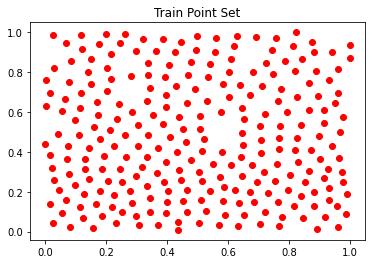

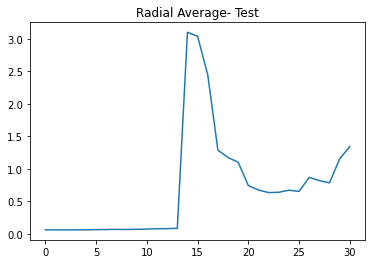

In [ ]:
output = tf.squeeze(output,0)
output = tf.reshape(output, (256,2))
output = toroidalWrapAround(output)
print(output.shape)
#output= tf.make_ndarray(output)
np.savetxt('output_train.txt', output)
plt.title('Train Point Set')
plt.scatter(output[:,0], output[:,1], c='r')
plt.show()

output = tf.expand_dims(output,0)
spect = computeNoDCExpectedPowerSpectrum(output)
RA,_ = radialAverage(spect)
np.savetxt('radial_average_train.txt', RA)
plt.figure()
plt.plot(RA[1:])
plt.title('Radial Average- Test')
plt.show()


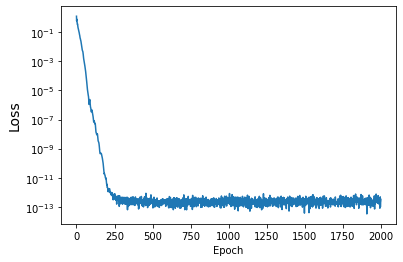

In [ ]:
plt.figure()
#train_loss_results = tf.make_ndarray(train_loss_results)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch")
plt.plot(train_loss_results)
plt.yscale('log')
plt.show()
np.savetxt('losses.txt', train_loss_results)

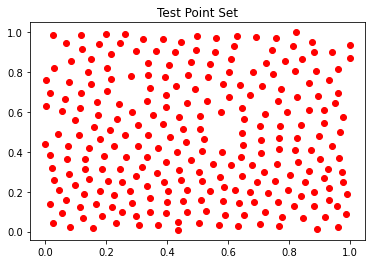

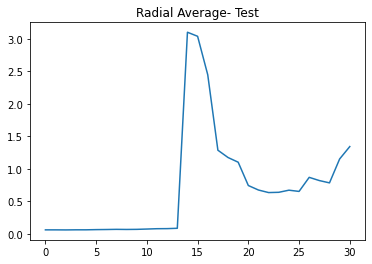

In [ ]:
################### TEST IT #######################################
filename = 'sample_data/2_plane_random_256.txt'
points,_ = read_2Dplane(filename)
points = points.reshape((1,512))
#points = np.expand_dims(points, 0)
points = tf.convert_to_tensor(points)


output = model(points, training=False)

output = tf.reshape(output, (256,2))
output = toroidalWrapAround(output)





#output = tf.make_ndarray(output)
np.savetxt('output_test.txt', output)
plt.title('Test Point Set')
plt.scatter(output[:,0], output[:,1], c='r')
plt.show()


#RA = tf.make_ndarray(RA)
output = tf.expand_dims(output,0)
spect = computeNoDCExpectedPowerSpectrum(output)
RA,_ = radialAverage(spect)
np.savetxt('radial_average_test.txt', RA)
#plt.figure()
#plt.plot(RA)
#plt.title('Radial Average- Test')
#plt.show()

plt.figure()
plt.plot(RA[1:])
plt.title('Radial Average- Test')
plt.show()